In [1]:
import torch

import numpy as np

from torchdiffeq import odeint_adjoint as odeint

from torchfilter.util import safe_cast

from pdes.models import ConvectionDiffusion

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use("ggplot")

In [2]:
device = torch.device('cpu')
NX = 512 # X is 256x256 mesh with dX = 2.5e-2

ts = 0.0005*torch.arange(1000., device=device)

### Generate Initial Condition

In [3]:
X,Y = torch.meshgrid(torch.linspace(-4, 4, NX), torch.linspace(-4, 4, NX))
x0 = torch.exp(-((X-3.)**2 + (Y)**2)/2).to(device)

In [4]:
dx = X[1,0]-X[0,0]

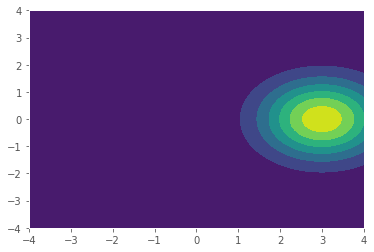

In [5]:
plt.contourf(X, Y, x0);

In [6]:
# x0 must be 1x1xNXxNX for filtering to work
# b x e x nx x ny , where b is batch size and e is dimension
#    nx,ny are spatial resolution (b,e  needed for linear algebra)

x0 = x0.view(-1,1,NX,NX)
print(x0.shape)

torch.Size([1, 1, 512, 512])


### Generate Velocity Field

Keep it simple as constant field for now

torch.Size([1, 2, 512, 512])


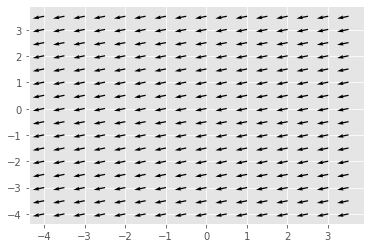

In [11]:
v = torch.cat(
    [
        -5*torch.ones_like(x0),
        -1*torch.ones_like(x0)
    ]
    ,1
)
print(v.shape)
_vx = NX//16
plt.quiver(
    X[::_vx,::_vx], Y[::_vx,::_vx],
    v[0,0,::_vx,::_vx], v[0,1,::_vx,::_vx]
);# plot 16x16 vector

In [12]:
pde = ConvectionDiffusion(
    params={'D': 0.1, 'v': v},
    dx = dx
)

In [13]:
xs = odeint(pde, x0, ts, method='euler')

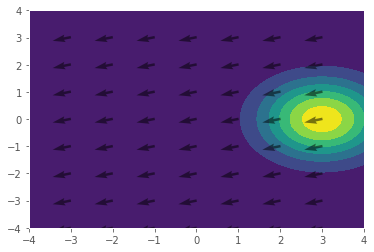

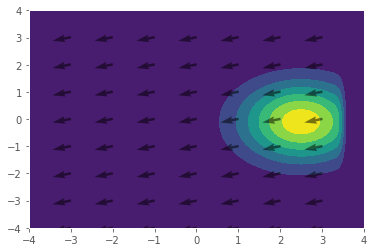

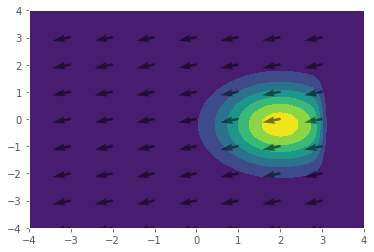

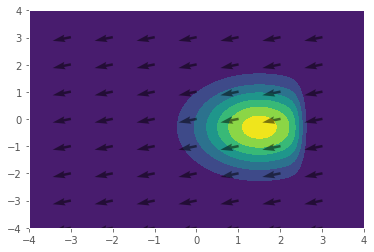

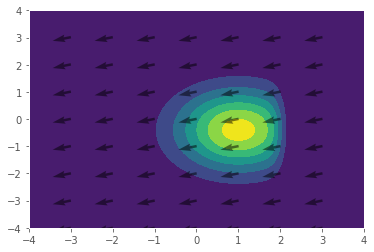

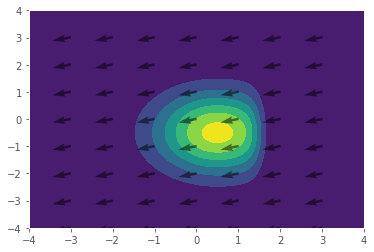

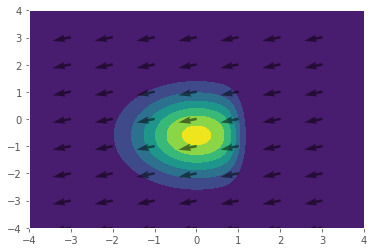

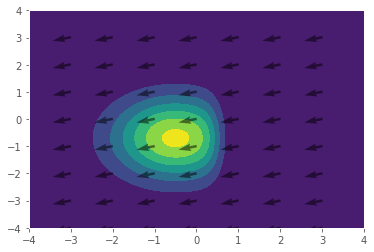

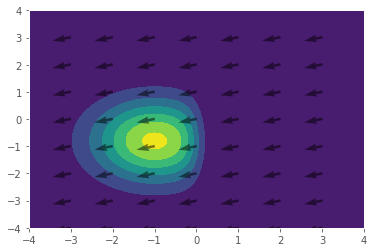

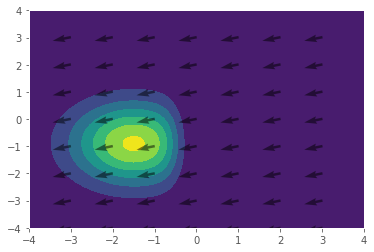

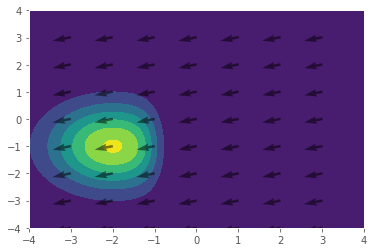

In [21]:
xs = xs.view(-1, NX, NX).detach()

clims = (xs.min(), xs.max())


_vx = NX//8
def quiv():
    plt.quiver(
        X[::_vx,::_vx], Y[::_vx,::_vx],
        v[0,0,::_vx,::_vx], v[0,1,::_vx,::_vx], alpha=0.5
    );

plt.figure()
plt.contourf(X, Y, xs[0, :, :])
plt.clim(*clims)
quiv()
for i in range(1,11):
    plt.figure()
    plt.contourf(X, Y, xs[(100*i)-1,:,:])
    plt.clim(*clims)
    quiv()

### Generate New (Random) Velocity Field

$$f \sim GP(\cdot,\cdot)$$
$$v = \nabla f$$

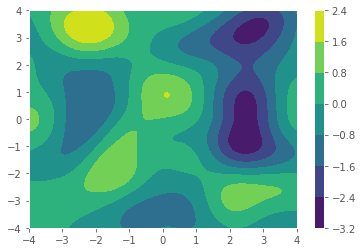

In [111]:
import gpytorch

with torch.no_grad():
    X,Y = torch.meshgrid(torch.linspace(-4, 4, NX), torch.linspace(-4, 4,NX))
    xy = torch.stack((X[::4,::4].reshape(-1),Y[::4,::4].reshape(-1)),-1)

    f = (gpytorch.kernels.RBFKernel()(xy) @ torch.randn(xy.shape[0],1)).view(NX//4, NX//4)
    
    f_ = f.view(1,1,NX//4,NX//4)
    f = torch.nn.functional.interpolate(f_, scale_factor=4, mode='bicubic', align_corners=True)
    plt.contourf(X,Y,0.05*f[0,0,:,:])
    plt.colorbar()

In [112]:
from pdes.ops import GradientFilter

grad = GradientFilter(dx, padding_mode='circular', device=device)

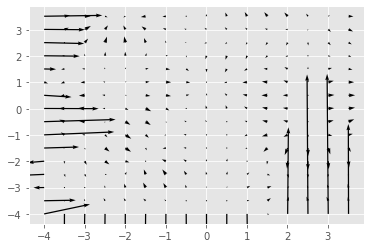

In [123]:
with torch.no_grad():
    v = grad(f)
    v = 500*(v/v.norm())
    _vx = NX//16
    plt.quiver(
        X[::_vx,::_vx], Y[::_vx,::_vx],
        v[0,0,::_vx,::_vx], v[0,1,::_vx,::_vx]
    ); # plot 16x16 vector

In [124]:
pde = ConvectionDiffusion(
    params={'D': 0.1, 'v': v},
    dx = dx, padding_mode='circular'
)

x0 = torch.exp(-((X+2)**2 + (Y-0.5)**2)/2).to(device)
x0 = x0.view(-1,1,NX,NX)

ts = 0.0005*torch.arange(4000., device=device)

xs = odeint(pde, x0, ts, method='euler')

C:\Users\wil-w\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


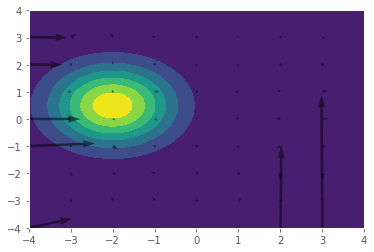

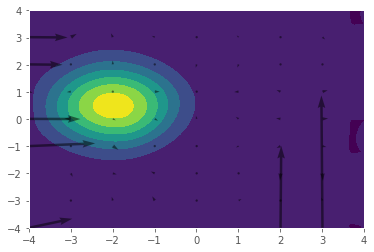

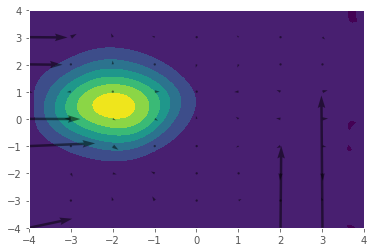

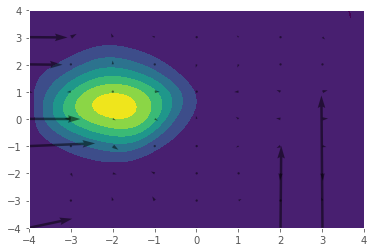

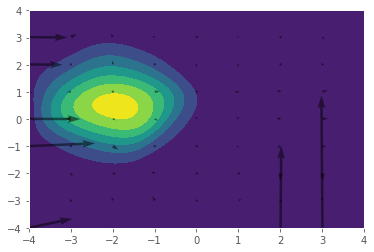

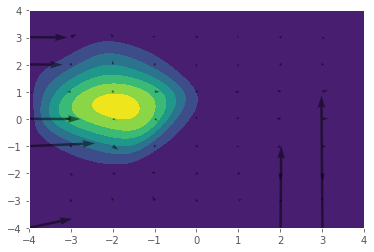

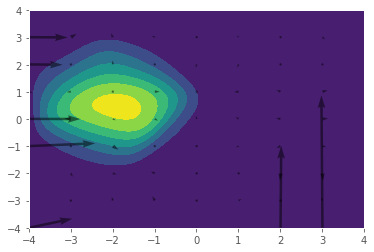

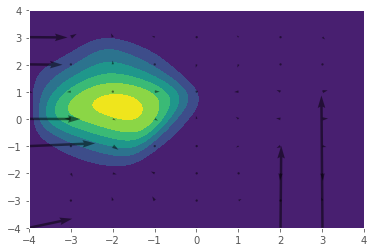

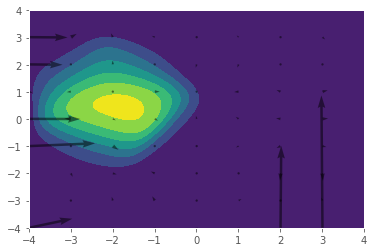

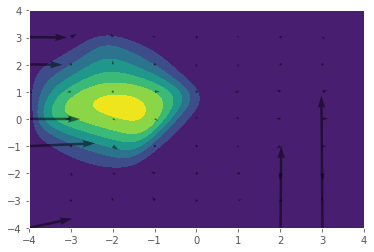

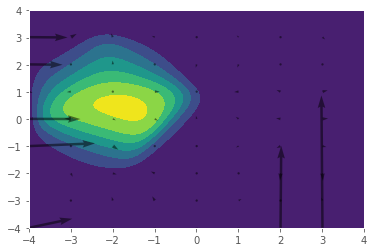

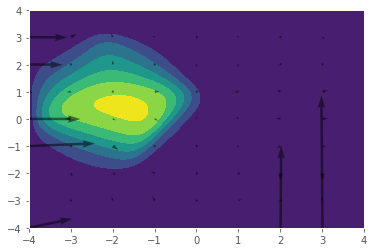

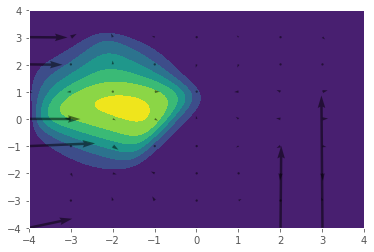

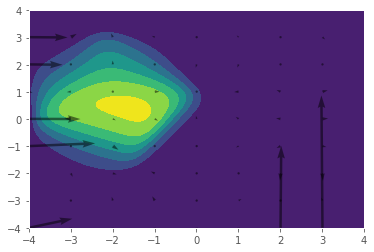

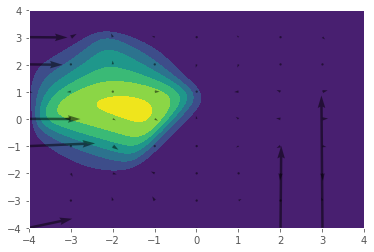

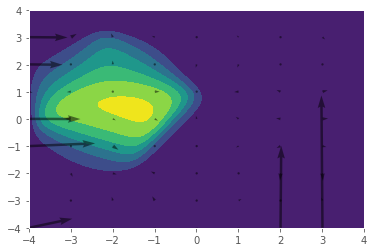

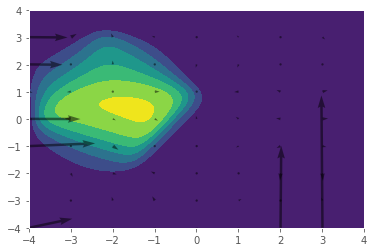

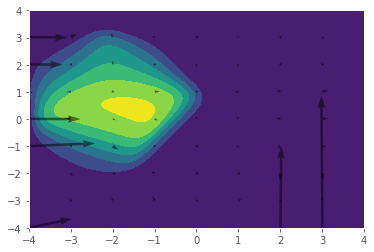

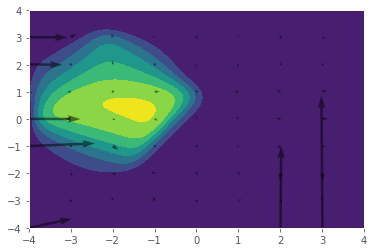

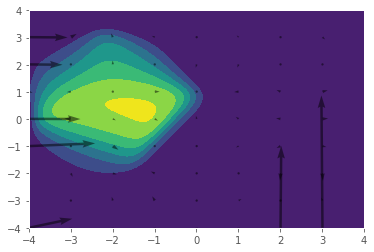

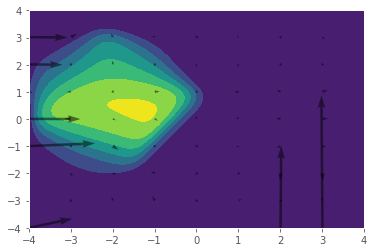

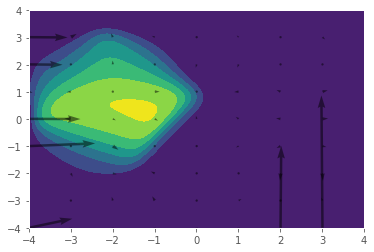

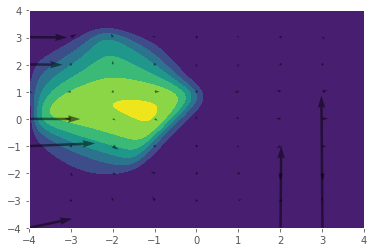

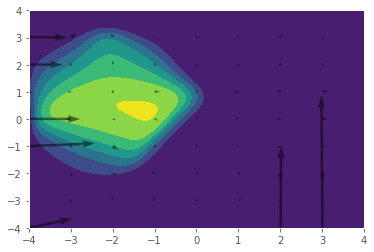

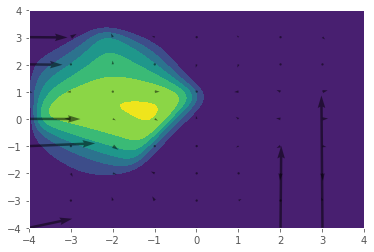

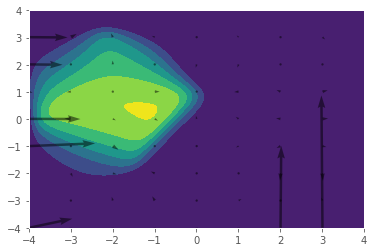

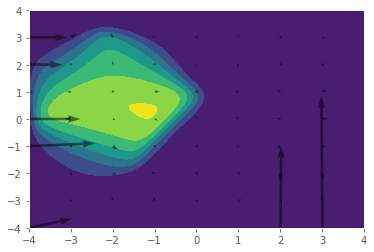

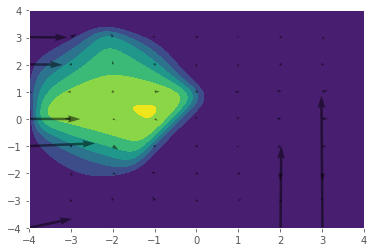

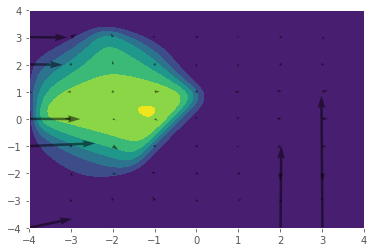

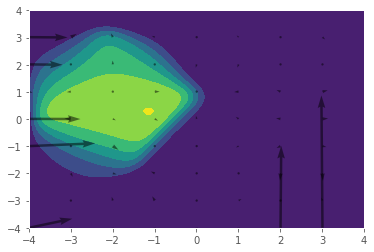

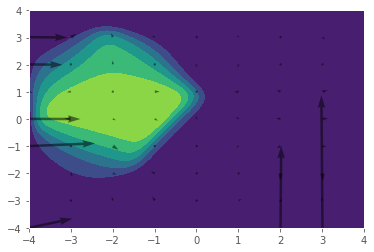

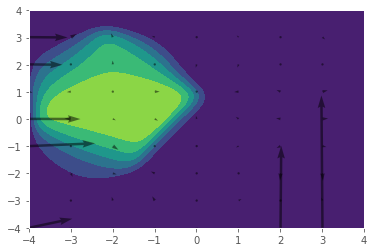

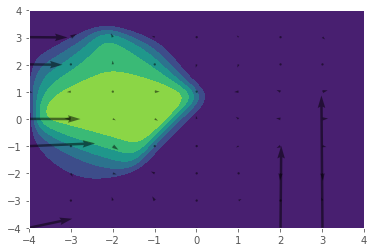

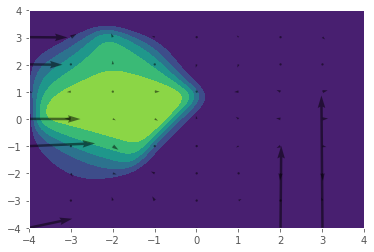

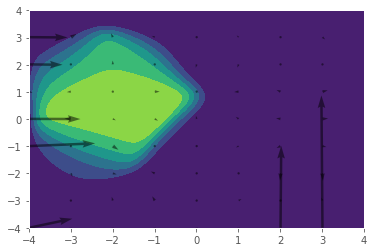

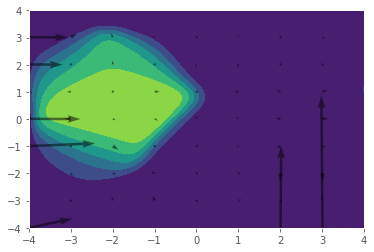

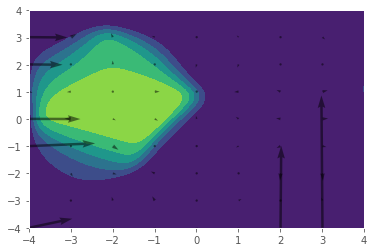

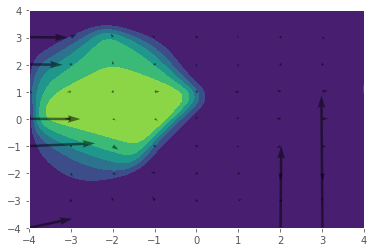

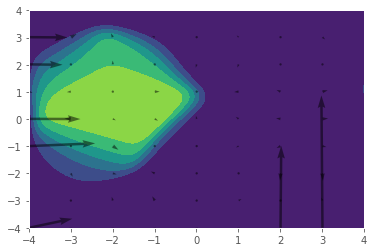

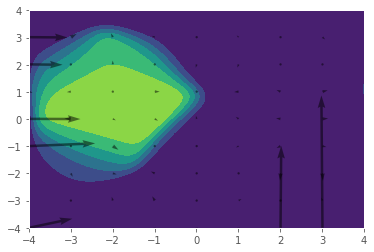

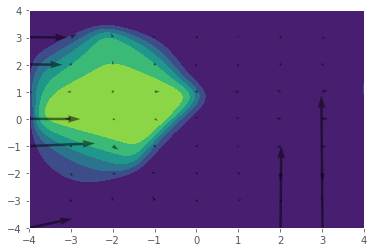

In [125]:
xs = xs.view(-1, NX, NX).detach()

clims = (xs.min(), xs.max())


_vx = NX//8
def quiv():
    plt.quiver(
        X[::_vx,::_vx], Y[::_vx,::_vx],
        v[0,0,::_vx,::_vx], v[0,1,::_vx,::_vx], alpha=0.5
    );

plt.figure()
plt.contourf(X, Y, xs[0, :, :])
plt.clim(*clims)
quiv()
for i in range(1,41):
    plt.figure()
    plt.contourf(X, Y, xs[(100*i)-1,:,:])
    plt.clim(*clims)
    quiv()

### A different initial condition

In [126]:
pde = ConvectionDiffusion(
    params={'D': 0.1, 'v': v},
    dx = dx, padding_mode='circular'
)

x0 = torch.exp(-((X)**2 + (Y-1.)**2)/2).to(device)
x0 = x0.view(-1,1,NX,NX)

ts = 0.0005*torch.arange(4000., device=device)

xs = odeint(pde, x0, ts, method='euler')

C:\Users\wil-w\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


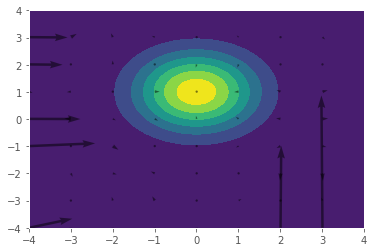

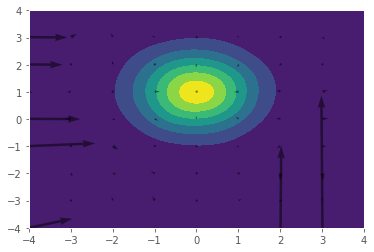

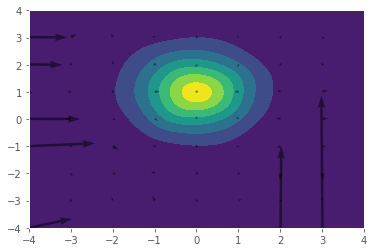

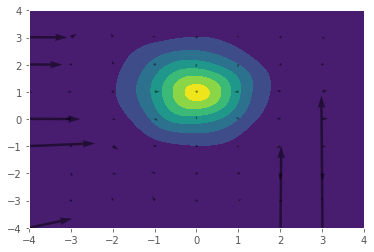

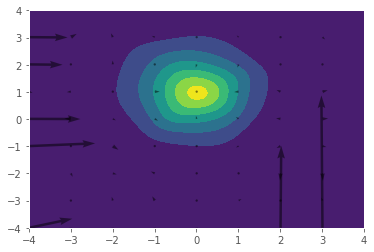

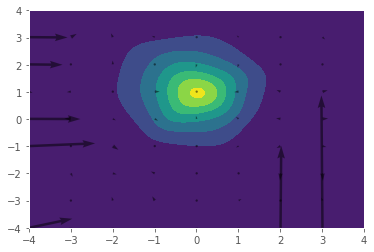

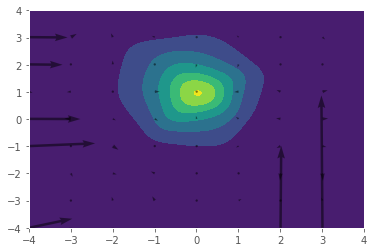

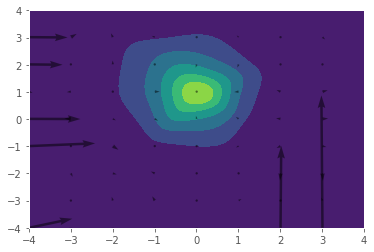

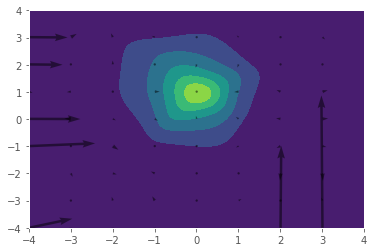

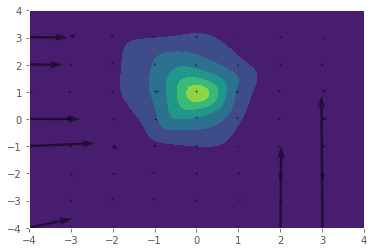

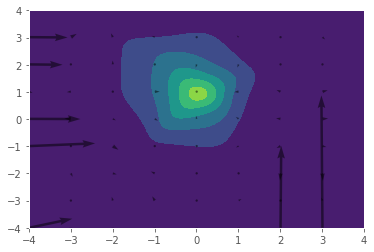

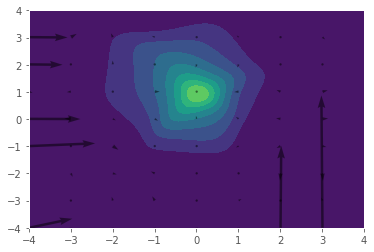

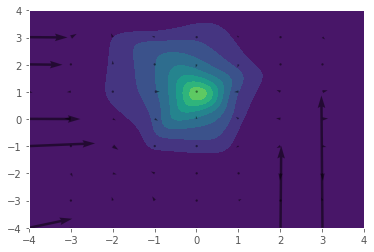

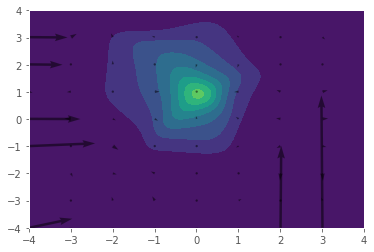

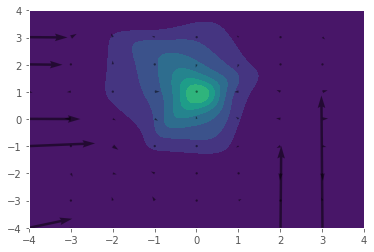

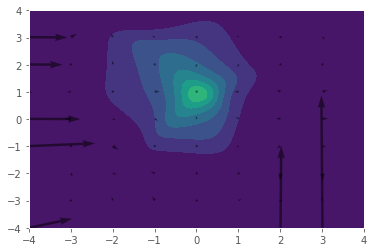

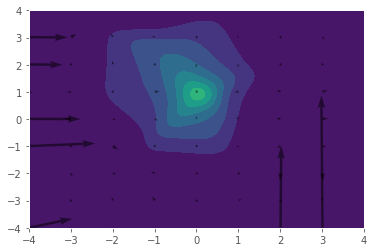

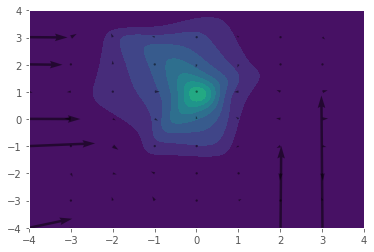

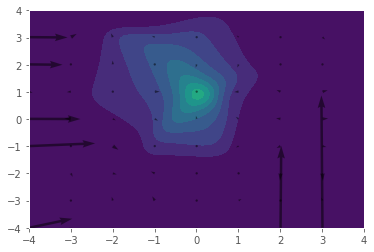

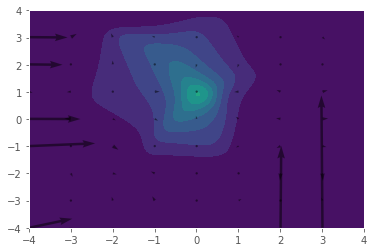

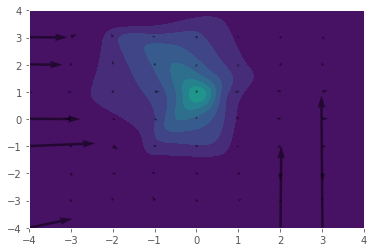

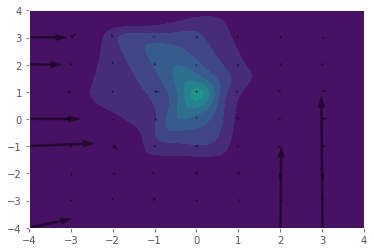

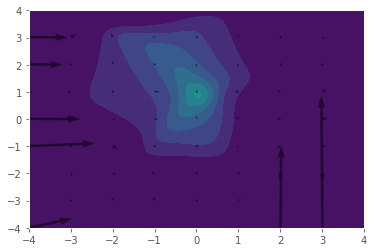

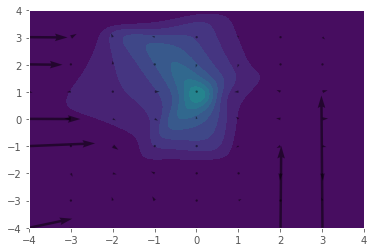

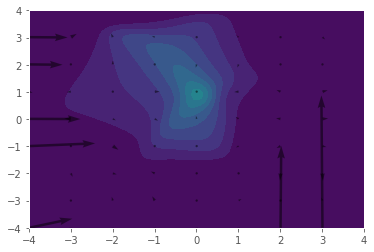

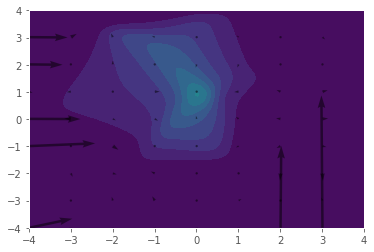

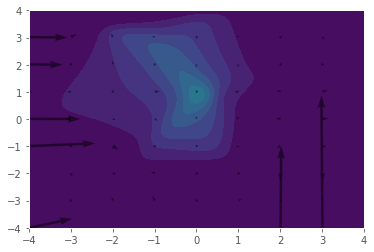

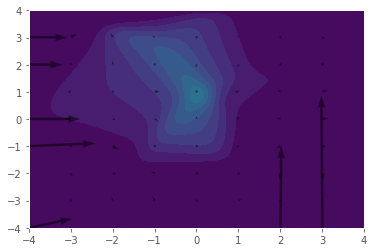

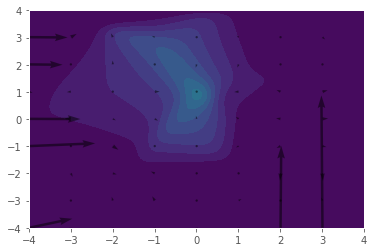

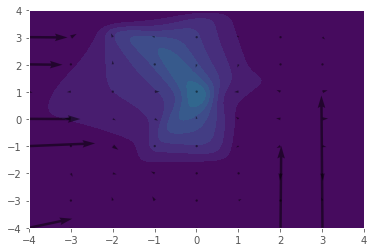

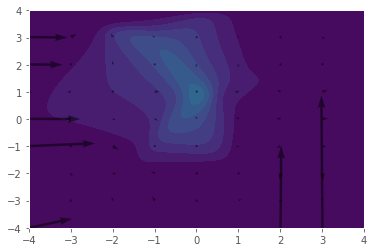

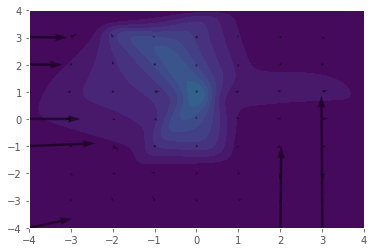

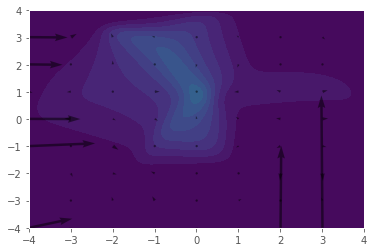

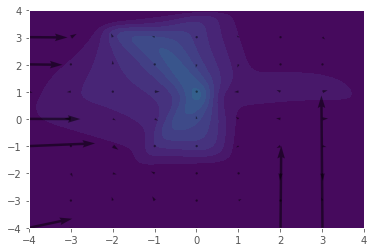

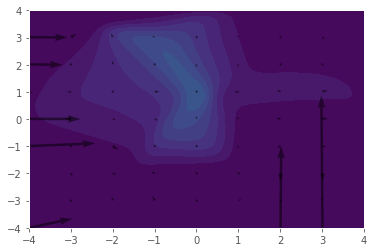

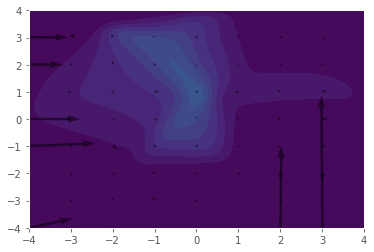

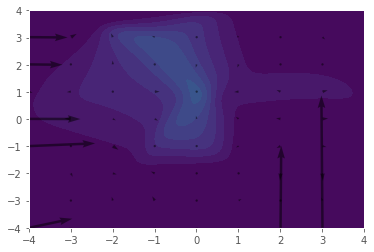

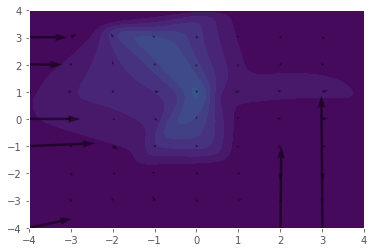

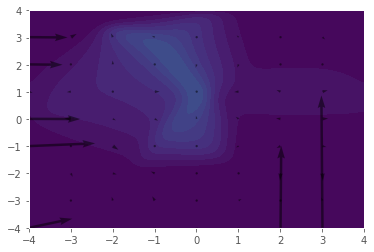

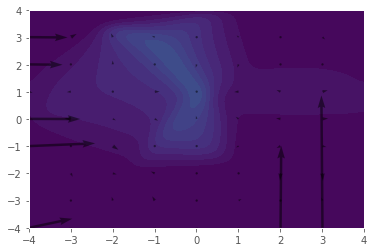

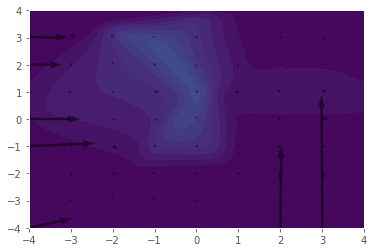

In [127]:
xs = xs.view(-1, NX, NX).detach()

clims = (xs.min(), xs.max())


_vx = NX//8
def quiv():
    plt.quiver(
        X[::_vx,::_vx], Y[::_vx,::_vx],
        v[0,0,::_vx,::_vx], v[0,1,::_vx,::_vx], alpha=0.5
    );

plt.figure()
plt.contourf(X, Y, xs[0, :, :])
plt.clim(*clims)
quiv()
for i in range(1,41):
    plt.figure()
    plt.contourf(X, Y, xs[(100*i)-1,:,:])
    plt.clim(*clims)
    quiv()

### Multi-modal initial condition

In [128]:
pde = ConvectionDiffusion(
    params={'D': 0.1, 'v': v},
    dx = dx, padding_mode='circular'
)

x0 = (torch.exp(-((X+1.)**2 + (Y-1.)**2)/2) + torch.exp(-((X-3)**2 + (Y+2)**2)/2)).to(device)
x0 = x0.view(-1,1,NX,NX)

ts = 0.0005*torch.arange(4000., device=device)

xs = odeint(pde, x0, ts, method='euler')

C:\Users\wil-w\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


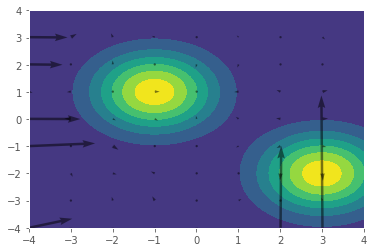

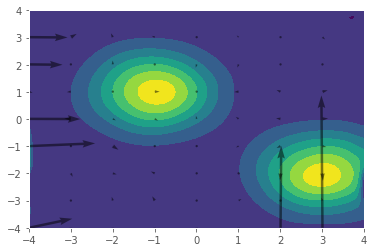

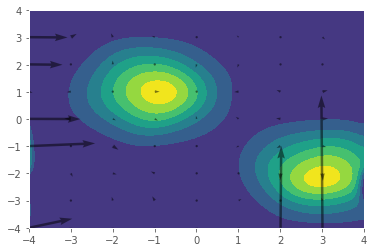

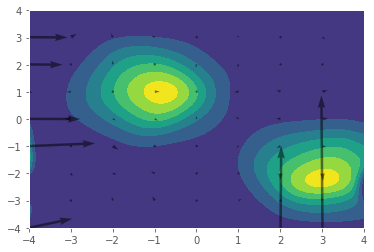

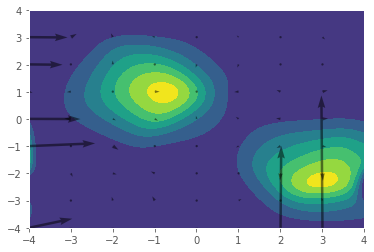

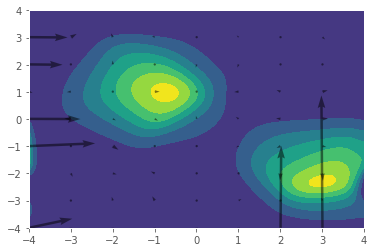

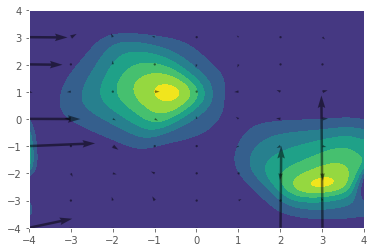

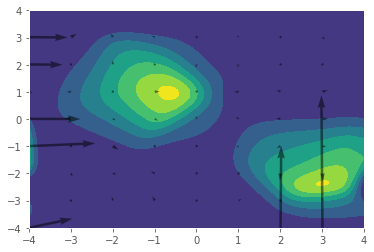

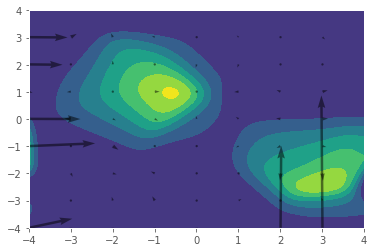

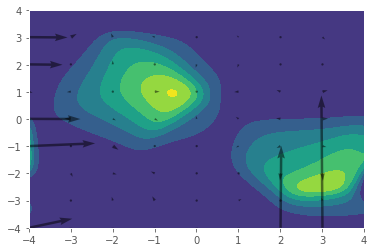

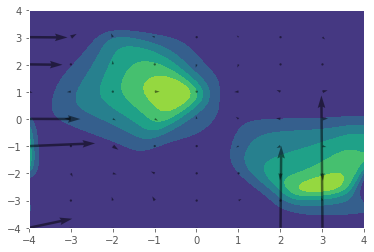

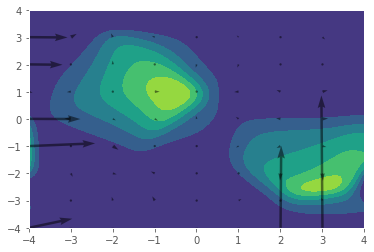

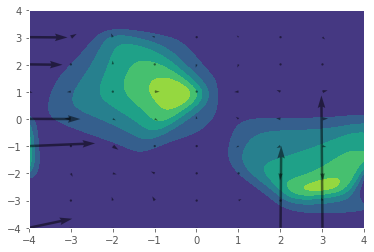

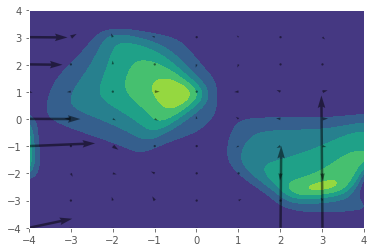

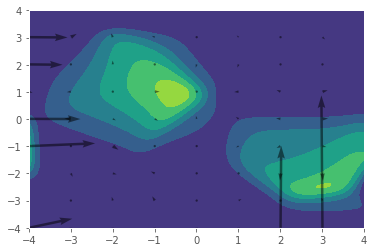

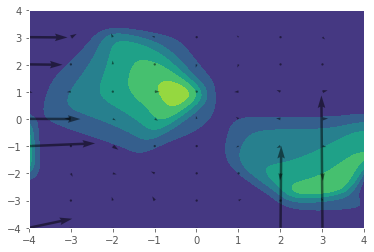

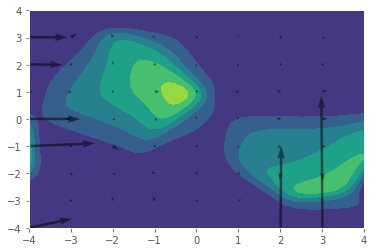

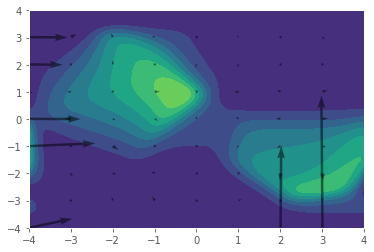

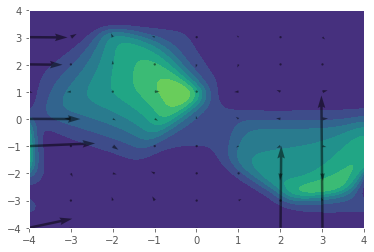

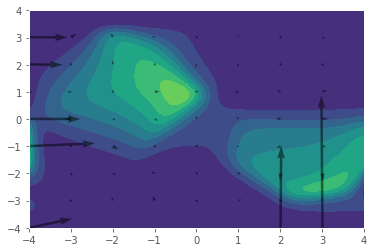

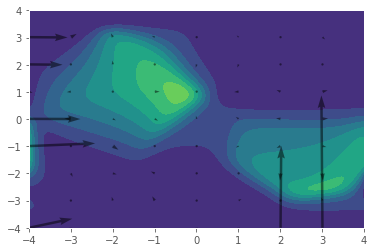

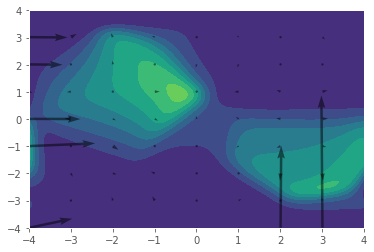

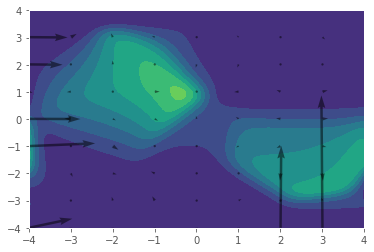

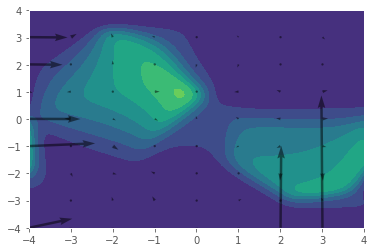

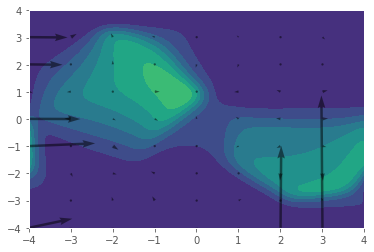

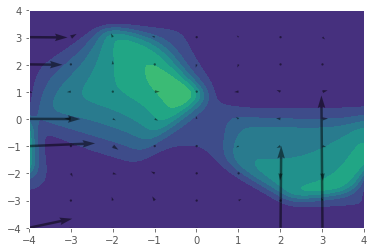

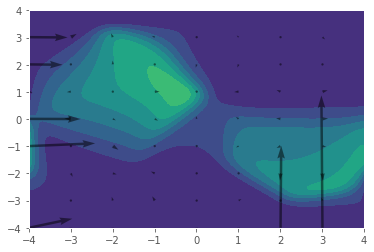

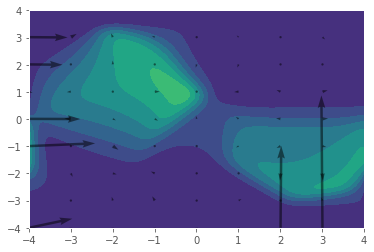

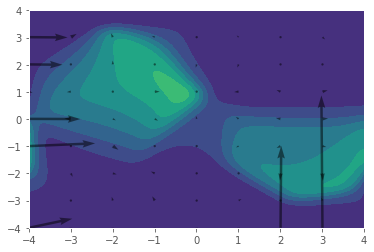

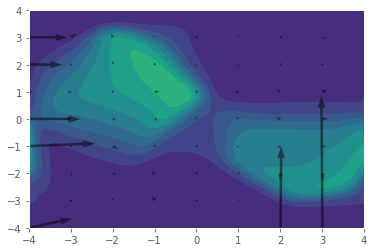

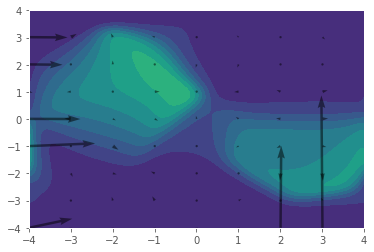

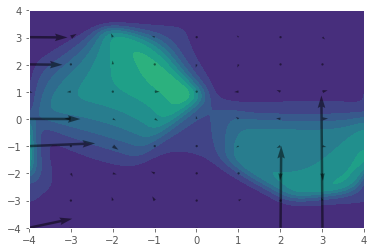

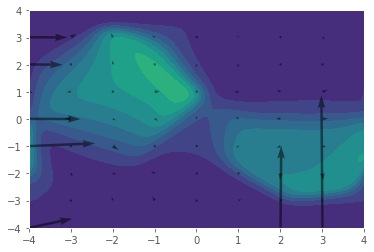

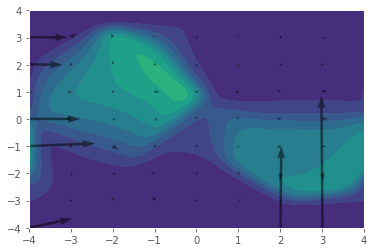

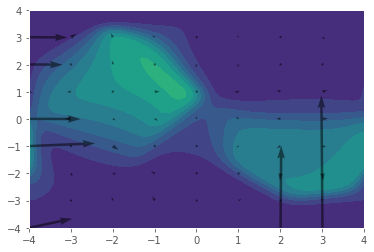

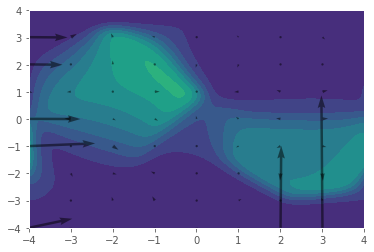

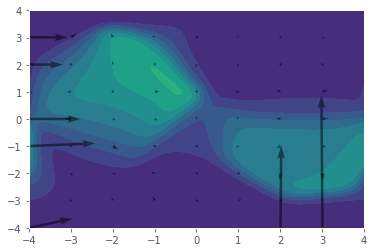

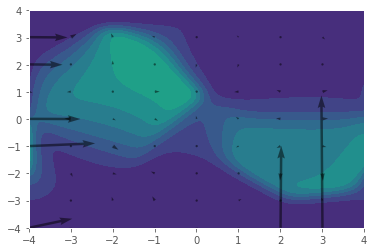

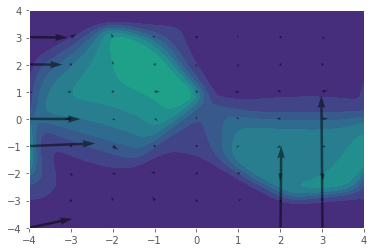

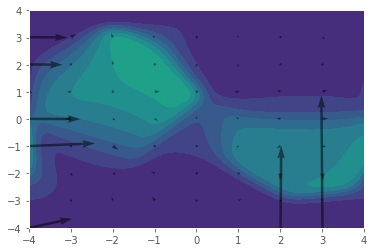

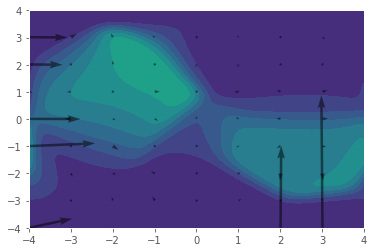

In [129]:
xs = xs.view(-1, NX, NX).detach()

clims = (xs.min(), xs.max())


_vx = NX//8
def quiv():
    plt.quiver(
        X[::_vx,::_vx], Y[::_vx,::_vx],
        v[0,0,::_vx,::_vx], v[0,1,::_vx,::_vx], alpha=0.5
    );

plt.figure()
plt.contourf(X, Y, xs[0, :, :])
plt.clim(*clims)
quiv()
for i in range(1,41):
    plt.figure()
    plt.contourf(X, Y, xs[(100*i)-1,:,:])
    plt.clim(*clims)
    quiv()